# Transfer Learning for Electircity-Demand of Schools

In [ ]:
# Getting energy for all schools and temperature for all schools

!wget https://github.com/akrymski1/BachelorsProject/raw/4d3b2fbf4b114278e828c129f8f5bbabcc26371a/all_schools_energy_data.csv.gz

!wget https://github.com/akrymski1/BachelorsProject/raw/4d3b2fbf4b114278e828c129f8f5bbabcc26371a/all_schools_weather_data.csv.gz

## Initialisation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from datetime import datetime, timedelta
import gc
from sklearn.utils import shuffle
import random

In [3]:
# Define the start and end dates
start_date = '2012-01-01 00:00:00'
end_date = '2012-12-31 23:59:59'

df_energy = pd.read_csv('/content/all_schools_energy_data.csv.gz', index_col = 0, parse_dates=True, compression='gzip')
df_weather = pd.read_csv('/content/all_schools_weather_data.csv.gz', index_col = 0, parse_dates=True, compression='gzip')


In [4]:
df_weather.columns = df_energy.columns

In [5]:
# Simple timeseries split
def split(x, y, ratio=0.8):
    i = int(ratio * len(x))
    return (x[:i], y[:i]), (x[i:], y[i:])

In [6]:
# Adding Time features
df_energy = df_energy.astype('float32')
# Create a new DataFrame with the same index as df_energy
df = pd.DataFrame(index=df_energy.index)

df['energy'] = df_energy['197']
# set to not adding weather
weather_bool = False

### Run the cell below if you want to add temp/weather as a feature

In [7]:
# RUN CELL IF YOU WANT TO ADD TEMPERATURE AS FEATURE
df_weather = df_weather.astype('float32')
df['temp'] = df_weather['197']
# weather has been added
weather_bool = True

### Adding New Features

In [8]:
# Add the new features
hour = ((df_energy.index.hour + df_energy.index.minute))

# Add the original 'day_of_week' and 'month' columns to df_time_features
df['day_of_week'] = df_energy.index.dayofweek
df['month'] = df_energy.index.month

df['hour_sin'] = np.sin(hour * (2 * np.pi / 24))
df['hour_cos'] = np.cos(hour * (2 * np.pi / 24))
# min-max scaling
df['hour_sin'] = (df['hour_sin'] - (-1)) / (1 - (-1))
df['hour_cos'] = (df['hour_cos'] - (-1)) / (1 - (-1))


# One-hot encode the 'day_of_week' and 'month' columns
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

# Define the school holiday dates
school_holidays = [
    [pd.Timestamp('2012-01-01')],  # New Year's Day
    [pd.Timestamp('2012-01-16')],  # Martin Luther King Jr. Day
    [pd.Timestamp('2012-02-20')],  # Presidents Day
    pd.date_range('2012-03-12', '2012-03-16'),  # Spring Break
    [pd.Timestamp('2012-05-28')],  # Memorial Day
    pd.date_range('2012-06-01', '2012-08-31'),  # Summer Break
    [pd.Timestamp('2012-09-03')],  # Labor Day
    [pd.Timestamp('2012-10-08')],  # Columbus Day
    [pd.Timestamp('2012-11-12')],  # Veterans Day observed
    pd.date_range('2012-11-19', '2012-11-23'),  # Fall Break (Thanksgiving week)
    pd.date_range('2012-12-24', '2012-12-31')  # Winter Break
]

# Flatten the list
school_holidays = pd.to_datetime([date for sublist in school_holidays for date in sublist])

# Create the school_holidays feature, setting it to 1 if the date is a school holiday and 0 otherwise
df['school_holiday'] = df.index.isin(school_holidays).astype(int)
df = df.astype('float32')
df

,energy,temp,hour_sin,hour_cos,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,school_holiday
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,32.0,10.0,0.500000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-01-01 01:00:00,31.0,10.0,0.629410,0.982963,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 02:00:00,31.0,9.0,0.750000,0.933013,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 03:00:00,32.0,9.0,0.853553,0.853553,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-01 04:00:00,32.0,8.0,0.933013,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,53.0,5.0,0.017037,0.629410,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-12-31 20:00:00,53.0,6.0,0.066987,0.750000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-12-31 21:00:00,53.0,6.0,0.146447,0.853553,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# looking at the order of the schools
schools = df_energy.columns
schools

Index(['197', '236', '153', '224', '218', '92', '144', '186', '136', '137',
       '109', '275', '103', '116', '100', '101', '111', '270', '259', '217',
       '88', '228', '214', '99', '213'],
      dtype='object')

## Pre-processing

### Normalisation

In [10]:
# Normalisation
timesteps = 24 * 7
steps = 24
features = df.values.shape[1]
length = len(df) - (timesteps + (steps))
batch_size = 64

# Handpicking schools for train, test and val to include schools from different locations and different sq_footage
# Schools to train / test on, 60:20:20 split
train = ['197', '103', '218', '92', '100', '99', '109', '137', '186', '224', '270', '153', '228', '101', '88']
test = ['213', '275', '116', '111', '259']
val = ['144', '136', '214', '236', '217']


print(train, test, val)
# Extract training columns
train_energy_columns = df_energy[train].values
energy_min = np.min(train_energy_columns)
energy_max = np.max(train_energy_columns)

# Min-Max scaling
df_energy[train] = (df_energy[train] - energy_min) / (energy_max - energy_min)
df_energy[test] = (df_energy[test] - energy_min) / (energy_max - energy_min)
df_energy[val] = (df_energy[val] - energy_min) / (energy_max - energy_min)

df['energy'] = (df['energy'] - energy_min) / (energy_max - energy_min)


if weather_bool:
  # Extract training columns
  train_weather_columns = df_weather[train].values
  weather_min = np.min(train_weather_columns)
  weather_max = np.max(train_weather_columns)

  # Min-Max scaling
  df_weather[train] = (df_weather[train] - weather_min) / (weather_max - weather_min)
  df_weather[test] = (df_weather[test] - weather_min) / (weather_max - weather_min)
  df_weather[val] = (df_weather[val] - weather_min) / (weather_max - weather_min)
  df['temp'] = (df['temp'] - weather_min) / (weather_max - weather_min)

['197', '236', '218', '92', '100', '99', '109', '137', '186', '224', '270', '153', '228', '101', '88'] ['213', '275', '116', '111', '259'] ['144', '136', '214', '103', '217']


### Windowing and Batching

In [18]:
# Windowing and making batches

train_steps_per_epoch = length * len(train) // batch_size
test_steps_per_epoch = length * len(test) // batch_size

# Sliding window transform (num_samples, features) to (num_samples, timesteps, features)
def window(data, timesteps, steps):
  X, y = [], []
  for i in range(len(data) - (timesteps + (steps))):
    X.append(data[i:i+timesteps])
    y.append(data[i+timesteps:i+timesteps+steps, 0])
  return np.array(X), np.array(y)

def get_school(school):
  df['energy'] = df_energy[school]
  if weather_bool: df['temp'] = df_weather[school]
  x, y = window(df.values, timesteps, steps)
  return (x, y)

# Generates batches of training data
def batch_generator(schools):
    while True:
      indices = np.random.permutation(length)
      for i in range(0, length, batch_size):
        x_batch = np.zeros((batch_size, timesteps, features))
        y_batch = np.zeros((batch_size, steps))

        for j, idx in enumerate(indices[i:i+batch_size]):
          school = np.random.choice(schools)
          y_batch[j] = df_energy[school].values[idx+timesteps:idx+timesteps+steps]
          x_batch[j] = df.values[idx:idx+timesteps]
          x_batch[j, :, 0] = df_energy[school].values[idx:idx+timesteps]
          if weather_bool: x_batch[j, :, 1] = df_weather[school].values[idx:idx+timesteps]

        yield x_batch, y_batch

X_test, y_test = get_school(test[0])
for school in test[1:]:
  x, y = get_school(school)
  X_test = np.concatenate((X_test, x))
  y_test = np.concatenate((y_test, y))

X_val, y_val = get_school(val[0])
for school in val[1:]:
  x, y = get_school(school)
  X_val = np.concatenate((X_val, x))
  y_val = np.concatenate((y_val, y))

# Training and test generators
train_gen = batch_generator(train)

print(X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(42960, 168, 24) (42960, 24) (42960, 168, 24) (42960, 24)


In [ ]:
# Making sure that data has no NaNs or Inf

def check_nan_inf(arrays):
  for arr in arrays:
    has_nan = np.isnan(arr).any()
    has_inf = np.isinf(arr).any()
    assert not (has_nan or has_inf)

check_nan_inf((X_test, y_test, X_val, y_val))

## Training Functions

In [ ]:
import keras_tuner as kt

In [ ]:
import glob
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import Sequential, Input
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense, Flatten, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from tensorflow.keras.models import Model
import json
from keras.utils import plot_model

In [ ]:
# COMPILE AND FIT FUNCTION

def compile_and_fit(model, train_gen, validation_data, epochs=10, ft=False, patience=10):
    # Define ModelCheckpoint and EarlyStopping
    ft = "_FT" if ft else ""
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model.name}_best{ft}.h5',
                                                    verbose=1,
                                                    monitor='val_loss',
                                                    save_best_only=True,
                                                    mode='min')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=0,
                                                      patience=patience,
                                                      verbose=1,
                                                      mode='min')


    learning_rate = 0.001

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train_gen,
                        validation_data=validation_data,
                        epochs=epochs,
                        verbose=1,
                        steps_per_epoch=train_steps_per_epoch,
                        callbacks=[checkpoint, early_stopping])
    return history

In [ ]:
def plot_week(X_test, y_test, y_pred, n=1):
  for w in range(0,n*timesteps,timesteps):
    x = X_test[w, :, 0]
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(x)+1), x, label='First Week Original')
    plt.plot(range(len(x)+1, len(x)+1+24), y_pred[w], 'r', label='Next Day Predicted')
    plt.plot(range(len(x)+1, len(x)+1+24), y_test[w], 'g', label='Next Day Original')
    plt.xlabel('Hour')
    plt.ylabel('Normalized Energy usage')
    plt.legend()
    plt.show()

In [ ]:
def descale(y_test):
  return (y_test * (energy_max - energy_min)) + energy_min

def eval(y_pred, y_test):
    y_pred = descale(y_pred)
    y_test = descale(y_test)
    # Reshape y_test and y_pred into continuous time series
    y_test_flat = y_test.ravel()
    y_pred_flat = y_pred.ravel()

    # Print mae and mse
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mape = (mae / np.mean(y_test)) *100

    return print(f"Overall MAE: {mae} , Overall MSE: {mse}, Approx. MAPE: {mape}")

def plot_history(history):
    epochs_range = range(len(history.history['loss']))
    plt.figure(figsize=(12, 6))
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Machine Learning Models

### Persisitence Model

In [ ]:
y_pred = np.empty(y_test.shape)

for i in range(len(X_test)):
  x = X_test[i][:, 0]
  y_pred[i] = x[-24:]

y_pred = np.array(y_pred)
eval(y_pred, y_test)

Overall MAE: 16.40736740823122 , Overall MSE: 1086.6172515280275, Approx. MAPE: 21.28891167090917


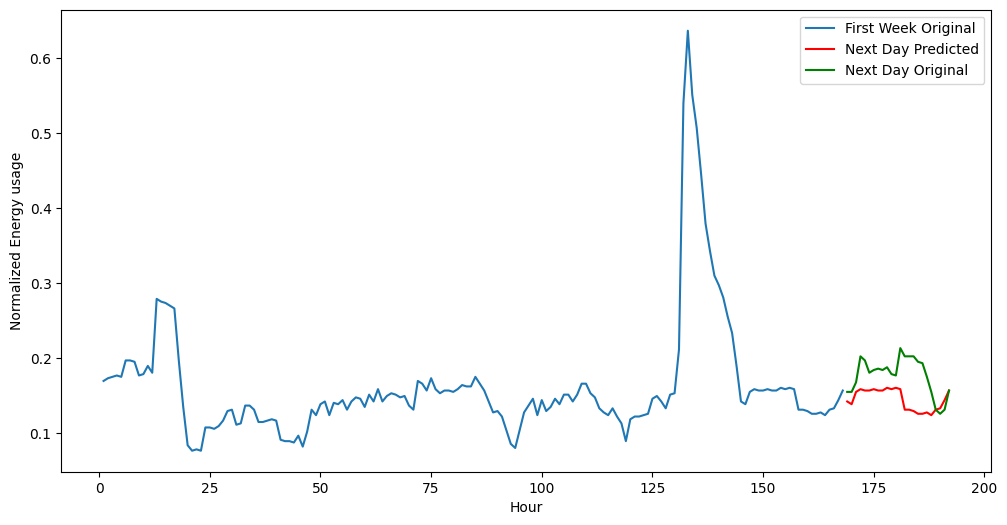

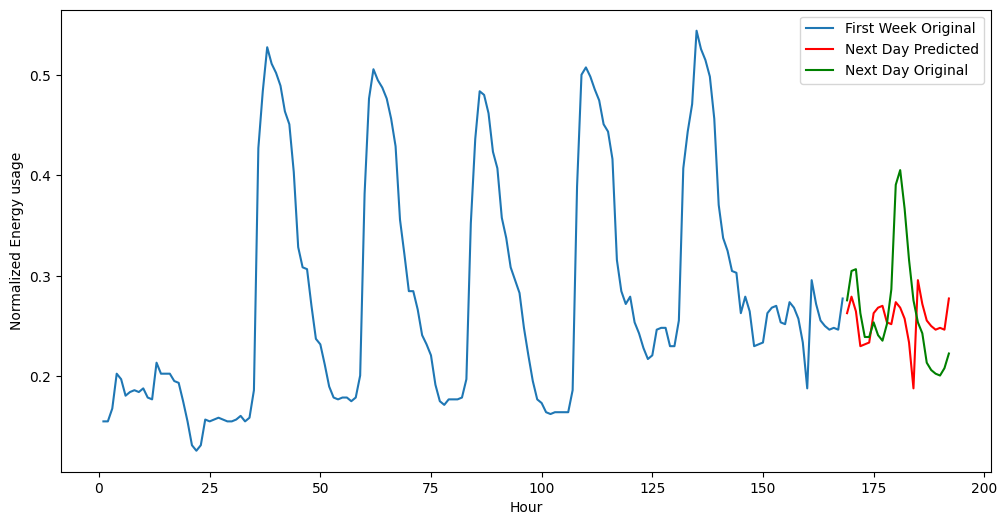

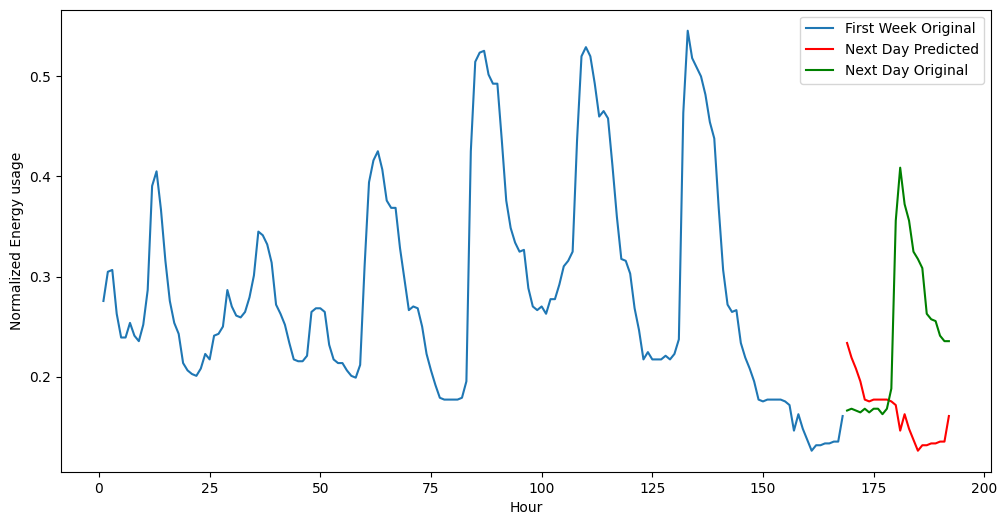

In [ ]:
plot_week(X_test, y_test, y_pred, 3)

### ARIMA

In [ ]:
!pip install pmdarima

In [ ]:
!pip install statsforecast

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Check for stationarity using the Augmented Dickey-Fuller test
pvals = []
for column in df_energy.columns:
  pvals.append(adfuller(df_energy[column])[1])


[1.4073019140917687e-11, 3.437781295390389e-22, 1.1005431221558721e-11, 5.705467073584658e-16, 1.1619342530622523e-18, 3.165813418600943e-18, 1.043879706033173e-14, 9.434852519366262e-24, 6.455059730373446e-26, 5.0150277427625523e-17, 8.75801327361362e-19, 2.2301505156322113e-17, 2.1270963951832772e-21, 2.9268115651287036e-18, 1.5175774020539188e-20, 2.5764506144926975e-15, 3.067294695067024e-12, 1.57588664942928e-06, 9.323482414989367e-26, 1.5230408439826072e-06, 3.067426146310872e-12, 5.135144176366006e-19, 2.2994530911426174e-20, 2.907731683511641e-19, 9.410669016567023e-17]


In [ ]:
pvals = np.array(pvals)
if (np.all(pvals < 0.05)):
  print("All data is stationary")

All data is stationary


In [ ]:
# SOURCE = https://alkaline-ml.com/pmdarima/auto_examples/arima/example_add_new_samples.html
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

def arima(series, steps=steps):

  df = pd.DataFrame({
      'ds': pd.to_datetime(series.index),
      'y': series.values
  })

  df['unique_id'] = 'X'

  mae, mse = [], []

  mstl = MSTL(
      season_length=[24, 24 * 7], # seasonalities of the time series
      trend_forecaster=AutoARIMA() # model used to forecast trend
  )

  sf = StatsForecast(
      models=[mstl], # model used to fit each time series
      freq='H', # frequency of the data
  )

  for i in range(timesteps, len(df)):
    x = df[:i]
    y = df['y'][i:i+steps]

    if i % (timesteps) == 0:
      sf = sf.fit(df=x)
      y_pred = sf.predict(h=steps)['MSTL']
      mae.append(mean_absolute_error(y, y_pred))
      mse.append(mean_squared_error(y, y_pred))

  return np.mean(np.array(mae)), np.mean(np.array(mse))

maes, mses, smapes = 0, 0, 0

for i, school in enumerate(test):
  mae, mse = arima(descale(df_energy[school]))
  print(school, mae, mse)
  maes += mae
  mses += mse
mae = maes / len(test)
mse = mses / len(test)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


101 26.054287 1150.4058
111 12.166198 264.59827
270 6.3651533 65.9843
259 21.276676 671.78644
217 6.355384 65.97675


In [ ]:
mape = (mae / np.mean(descale(y_test)))*100

In [ ]:
print(mae)
print(mse)
print(mape)

14.4435396194458
443.7503036499023
18.74080292853069


### LSTM

In [ ]:
# SOURCE = https://www.mdpi.com/2071-1050/15/3/2340

lstm = Sequential(name="lstm")
lstm.add(LSTM(8, return_sequences=True, input_shape=(timesteps, features)))
lstm.add(LSTM(16, return_sequences=True))
lstm.add(LSTM(32, return_sequences=True))
lstm.add(LSTM(32, return_sequences=True))
lstm.add(LSTM(64, return_sequences=False))
lstm.add(Dropout(0.5))
lstm.add(Dense(24, activation='sigmoid'))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 8)            1024      
                                                                 
 lstm_1 (LSTM)               (None, 168, 16)           1600      
                                                                 
 lstm_2 (LSTM)               (None, 168, 32)           6272      
                                                                 
 lstm_3 (LSTM)               (None, 168, 32)           8320      
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 24)                1560   

#### Not using Weather

In [ ]:
# NO WEATHER
history = compile_and_fit(lstm, train_gen, (X_val, y_val), 50, ft=False)

Epoch 1/50
2013/2013 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0693
Epoch 1: val_loss improved from inf to 0.00434, saving model to lstm_best.h5
2013/2013 [==============================] - 107s 46ms/step - loss: 0.0094 - mean_absolute_error: 0.0693 - val_loss: 0.0043 - val_mean_absolute_error: 0.0458
Epoch 2/50
2012/2013 [============================>.] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0415
Epoch 2: val_loss improved from 0.00434 to 0.00295, saving model to lstm_best.h5
2013/2013 [==============================] - 88s 44ms/step - loss: 0.0033 - mean_absolute_error: 0.0415 - val_loss: 0.0029 - val_mean_absolute_error: 0.0344
Epoch 3/50
2013/2013 [==============================] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0359
Epoch 3: val_loss improved from 0.00295 to 0.00272, saving model to lstm_best.h5
2013/2013 [==============================] - 83s 41ms/step - loss: 0.0026 - mean_absolute_error: 0.0359 - val_loss: 0.0

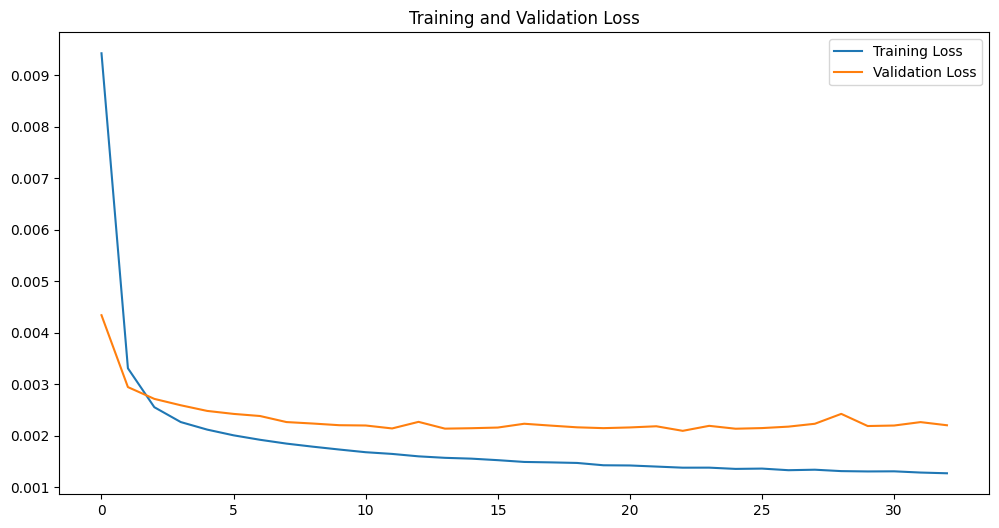

In [ ]:
plot_history(history)

In [ ]:
lstm = load_model('/content/lstm_best_noWeather.h5')

In [ ]:
# Unnormalised
y_pred = lstm.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 18s 13ms/step
Overall MAE: 13.739715576171875 , Overall MSE: 467.0726013183594, Approx. MAPE: 17.827576398849487


In [ ]:
# Testing on test set (normalised)
y_pred = lstm.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 18s 12ms/step
Overall MAE: 0.025330904871225357 , Overall MSE: 0.0015976623399183154 , 


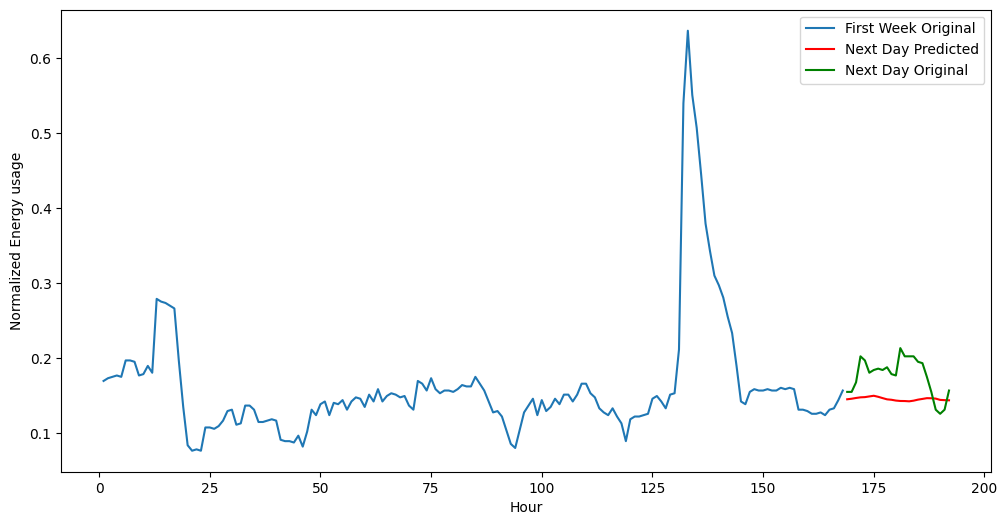

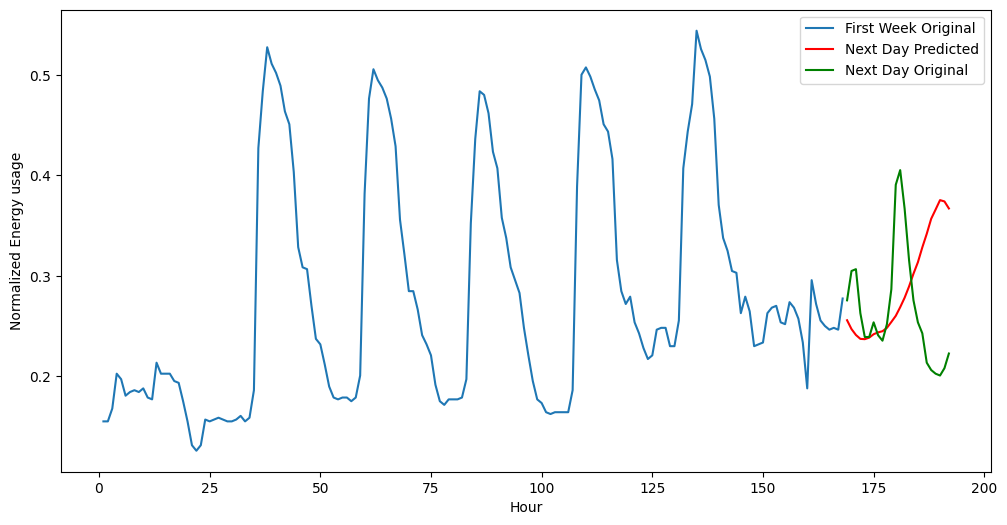

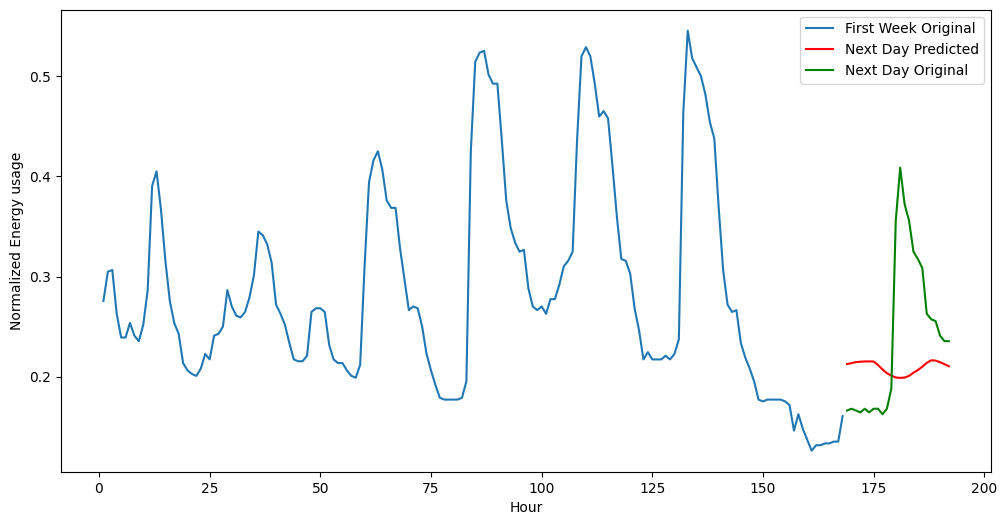

In [ ]:
plot_week(X_test, y_test, y_pred, n=3)

#### Using Weather

In [ ]:
# WEATHER
history = compile_and_fit(lstm, train_gen, (X_val, y_val), 50, ft=False)

Epoch 1/50
2012/2013 [============================>.] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0639
Epoch 1: val_loss improved from inf to 0.00349, saving model to lstm_best.h5
2013/2013 [==============================] - 105s 44ms/step - loss: 0.0084 - mean_absolute_error: 0.0639 - val_loss: 0.0035 - val_mean_absolute_error: 0.0399
Epoch 2/50
2013/2013 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0395
Epoch 2: val_loss improved from 0.00349 to 0.00269, saving model to lstm_best.h5
2013/2013 [==============================] - 84s 42ms/step - loss: 0.0030 - mean_absolute_error: 0.0395 - val_loss: 0.0027 - val_mean_absolute_error: 0.0328
Epoch 3/50
2013/2013 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0353
Epoch 3: val_loss improved from 0.00269 to 0.00248, saving model to lstm_best.h5
2013/2013 [==============================] - 88s 44ms/step - loss: 0.0025 - mean_absolute_error: 0.0353 - val_loss: 0.0

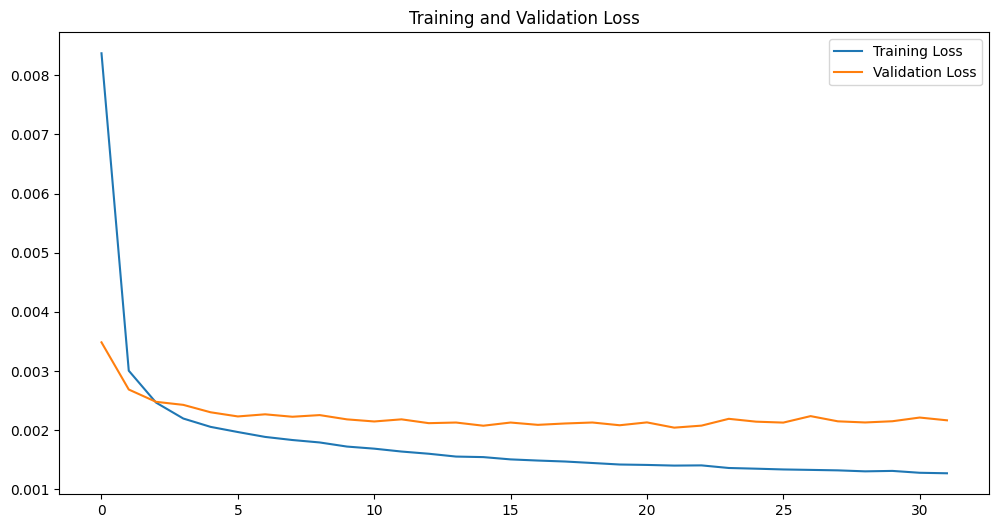

In [ ]:
# Check for overfitting, earlystopped at epoch 23
plot_history(history)

In [ ]:
lstm = load_model('/content/lstm_best_weather.h5')

In [ ]:
# Unnormalised
y_pred = lstm.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 49s 27ms/step
Overall MAE: 13.128292083740234 , Overall MSE: 419.350341796875, Approx. MAPE: 17.034241557121277


In [ ]:
# Testing on test set normalised
y_pred = lstm.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 17s 12ms/step
Overall MAE: 0.02446182444691658 , Overall MSE: 0.0015067134518176317 , 


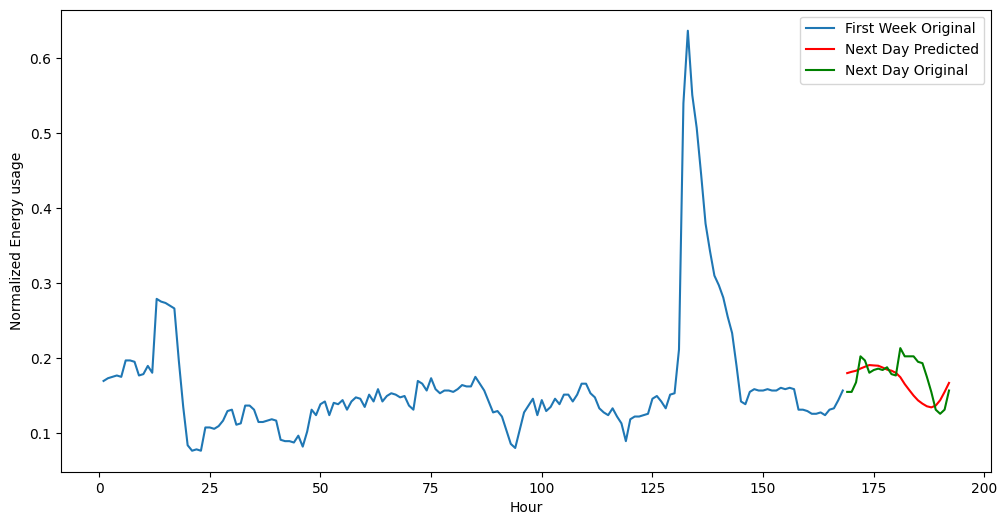

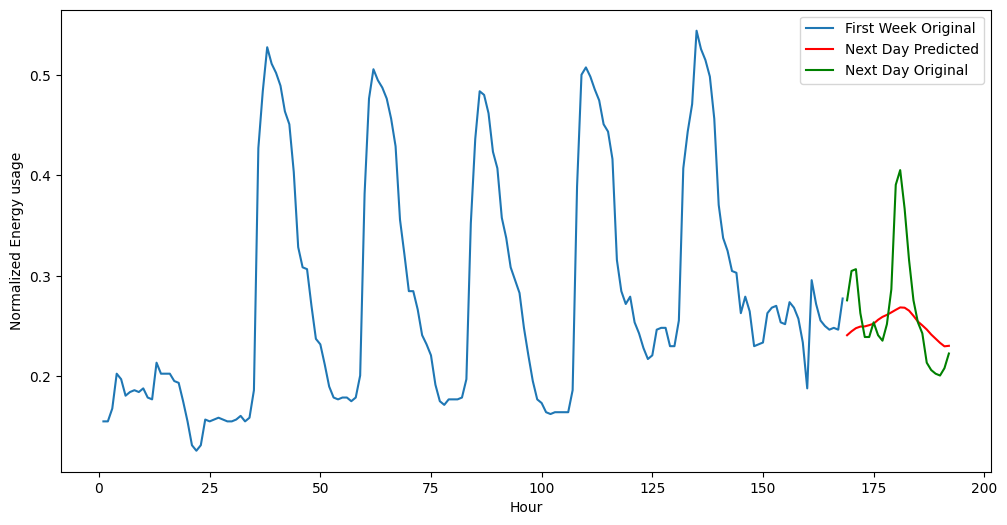

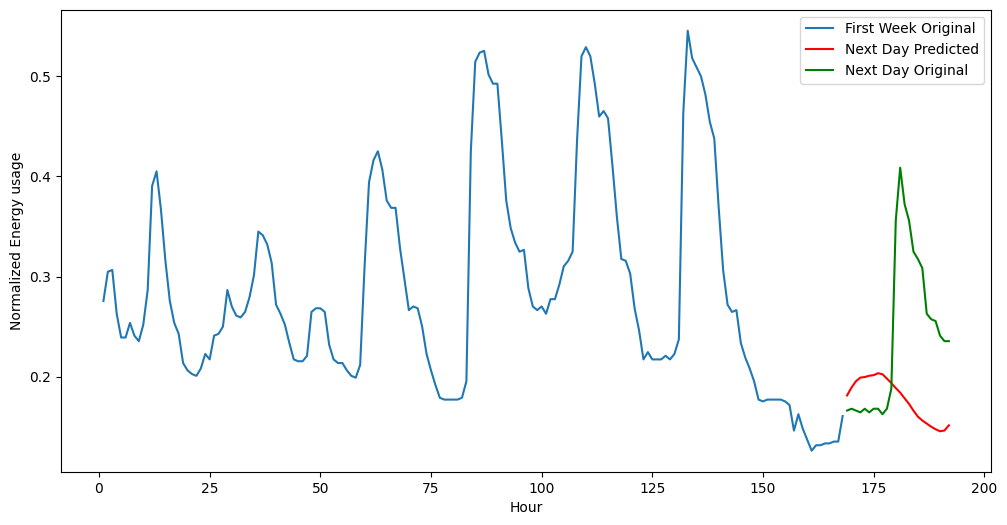

In [ ]:
plot_week(X_test, y_test, y_pred, n=3)

In [ ]:
gc.collect()

1488

### 1D-CNN

In [ ]:
# https://arxiv.org/pdf/1611.06455.pdf
# fcn

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, add, Activation

model = Sequential(name='cnn')

# First convolution block with kernel size 8 and 128 filters
model.add(Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', input_shape=(timesteps, features)))

# Second convolution block with kernel size 5 and 256 filters
model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))

# Third convolution block with kernel size 3 and 128 filters
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))

# Global average pooling layer
model.add(GlobalAveragePooling1D())

# Softmax layer
model.add(Dense(24, activation='sigmoid'))

model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 168, 128)          24704     
                                                                 
 conv1d_4 (Conv1D)           (None, 168, 256)          164096    
                                                                 
 conv1d_5 (Conv1D)           (None, 168, 128)          98432     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
Total params: 290,328
Trainable params: 290,328
Non-trainable params: 0
_________________________________________________________

#### No Weather

In [ ]:
# TRAINING WITH NO WEATHER DATA
history = compile_and_fit(model, train_gen, (X_val, y_val), 50, ft=False)

Epoch 1/50
2013/2013 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0511
Epoch 1: val_loss improved from inf to 0.00368, saving model to cnn_best.h5
2013/2013 [==============================] - 41s 14ms/step - loss: 0.0056 - mean_absolute_error: 0.0511 - val_loss: 0.0037 - val_mean_absolute_error: 0.0408
Epoch 2/50
2011/2013 [============================>.] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0309
Epoch 2: val_loss improved from 0.00368 to 0.00336, saving model to cnn_best.h5
2013/2013 [==============================] - 26s 13ms/step - loss: 0.0021 - mean_absolute_error: 0.0309 - val_loss: 0.0034 - val_mean_absolute_error: 0.0388
Epoch 3/50
2013/2013 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0293
Epoch 3: val_loss improved from 0.00336 to 0.00302, saving model to cnn_best.h5
2013/2013 [==============================] - 26s 13ms/step - loss: 0.0019 - mean_absolute_error: 0.0293 - val_loss: 0.0030 

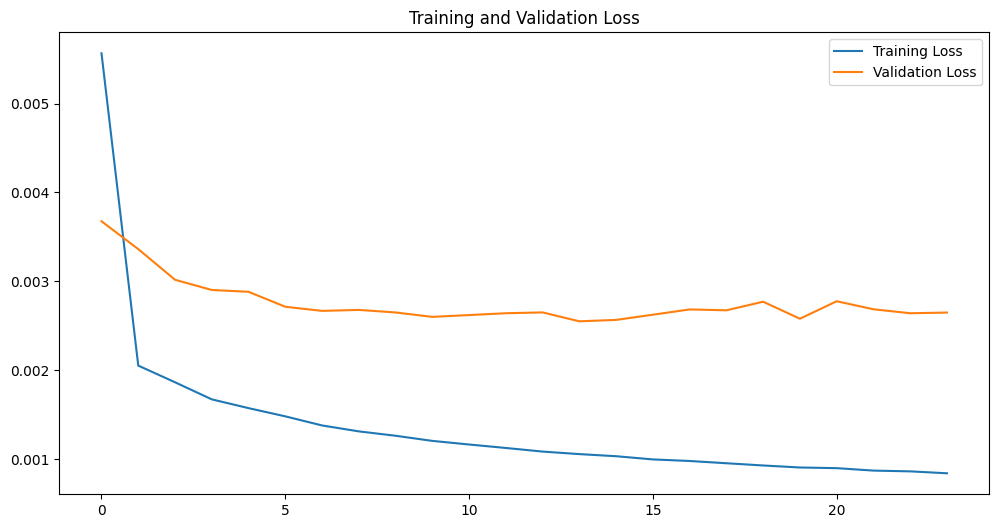

In [ ]:
plot_history(history)

In [ ]:
model = load_model('/content/cnn_best_noWeather.h5')

In [ ]:
# Unnormalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 5s 4ms/step
Overall MAE: 15.658573150634766 , Overall MSE: 579.4733276367188, Approx. MAPE: 20.317335426807404


In [ ]:
# Testing on test set normalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 4s 3ms/step
Overall MAE: 0.029208043590188026 , Overall MSE: 0.002025858499109745 , 


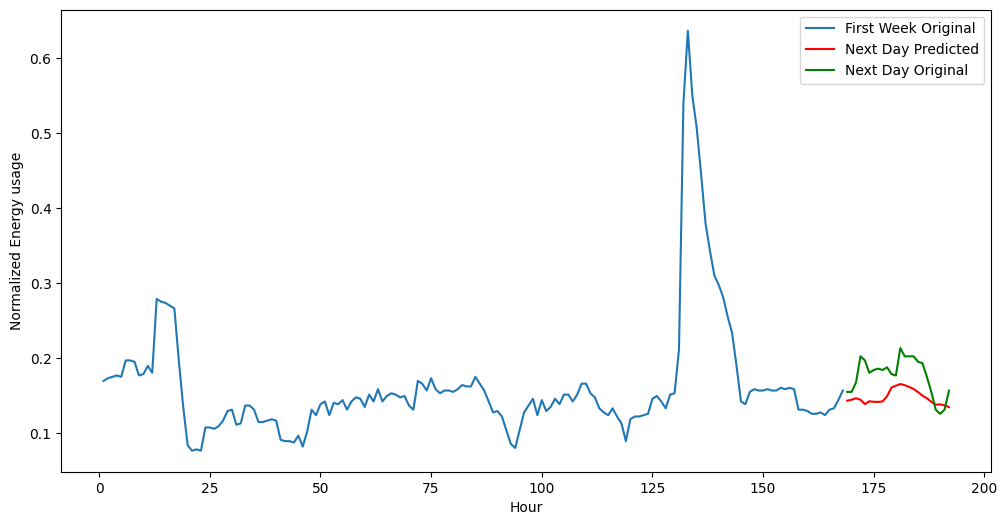

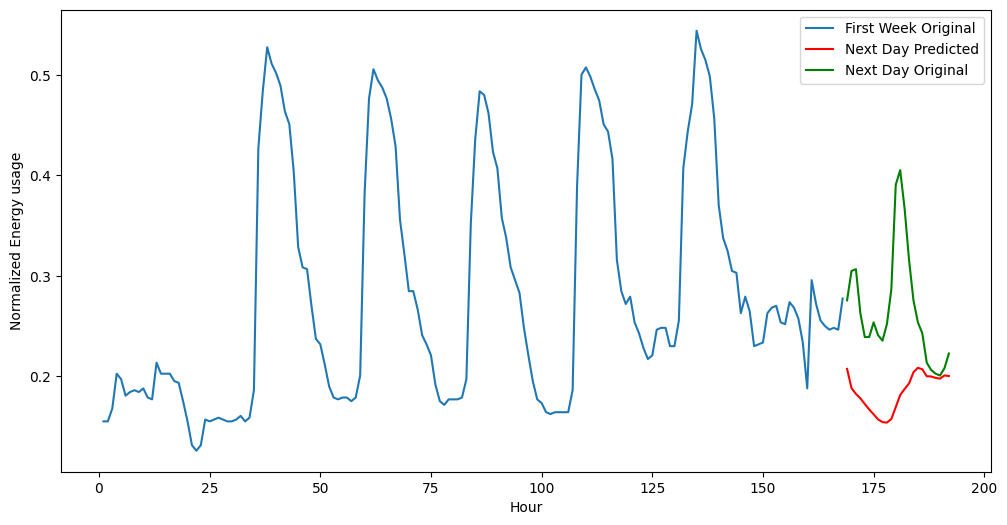

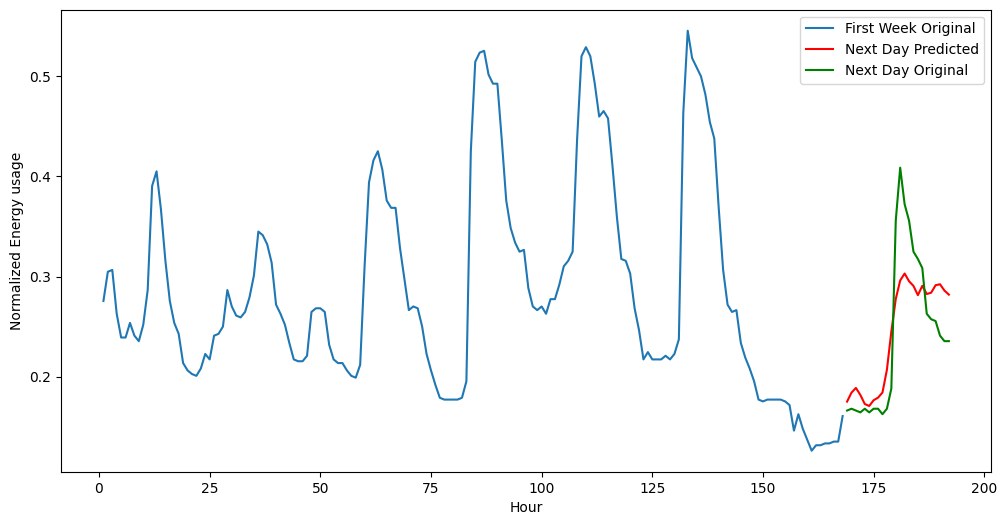

In [ ]:
plot_week(X_test, y_test, y_pred, n=3)

#### Weather

In [ ]:
# TRAINING WITH WEATHER DATA
history = compile_and_fit(model, train_gen, (X_val, y_val), 50, ft=False)

Epoch 1/50
2009/2013 [============================>.] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0489
Epoch 1: val_loss improved from inf to 0.00360, saving model to cnn_best.h5
2013/2013 [==============================] - 30s 14ms/step - loss: 0.0052 - mean_absolute_error: 0.0488 - val_loss: 0.0036 - val_mean_absolute_error: 0.0397
Epoch 2/50
2011/2013 [============================>.] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0303
Epoch 2: val_loss improved from 0.00360 to 0.00318, saving model to cnn_best.h5
2013/2013 [==============================] - 26s 13ms/step - loss: 0.0020 - mean_absolute_error: 0.0303 - val_loss: 0.0032 - val_mean_absolute_error: 0.0364
Epoch 3/50
2010/2013 [============================>.] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0282
Epoch 3: val_loss improved from 0.00318 to 0.00286, saving model to cnn_best.h5
2013/2013 [==============================] - 27s 13ms/step - loss: 0.0018 - mean_absolute_error: 0.0282 - val_loss: 0.0029 

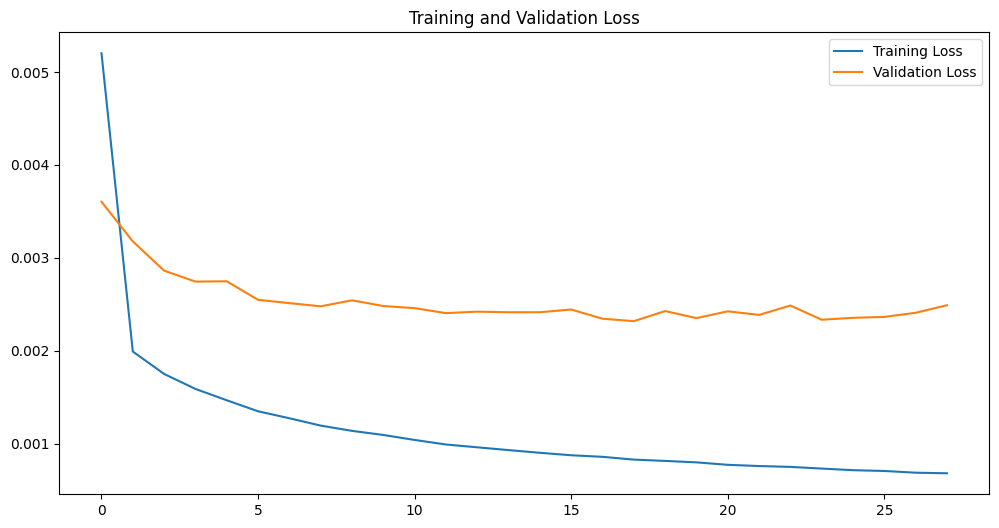

In [ ]:
plot_history(history)

In [ ]:
model = load_model('/content/cnn_best_weather.h5')

In [ ]:
# Unnormalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 7s 2ms/step
Overall MAE: 15.068195343017578 , Overall MSE: 503.6648864746094, Approx. MAPE: 19.55130696296692


In [ ]:
# Testing on test set normalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 3s 2ms/step
Overall MAE: 0.028308315202593803 , Overall MSE: 0.0018010684289038181 , 


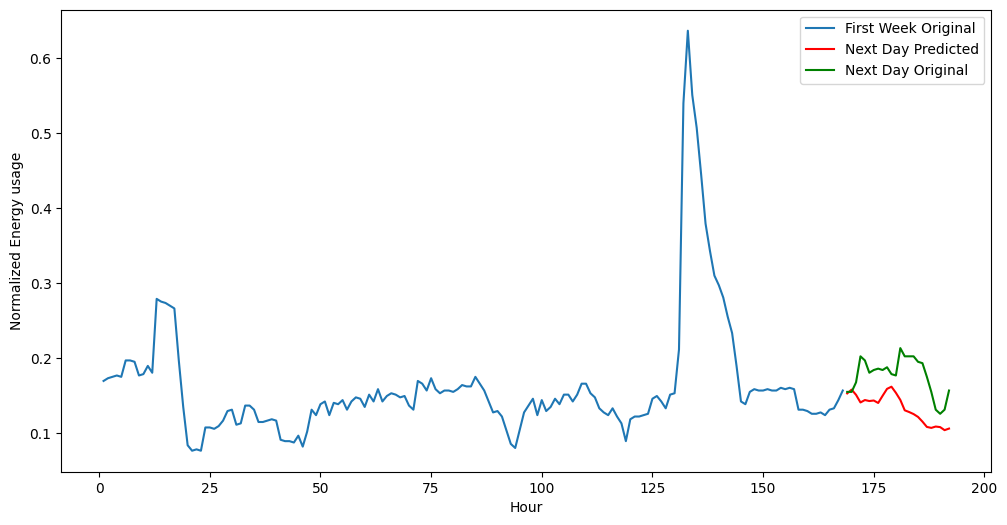

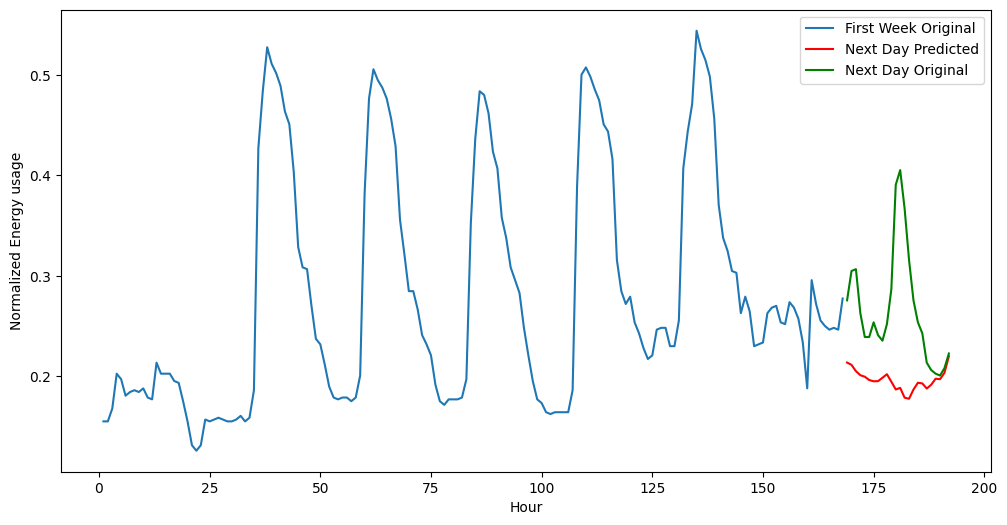

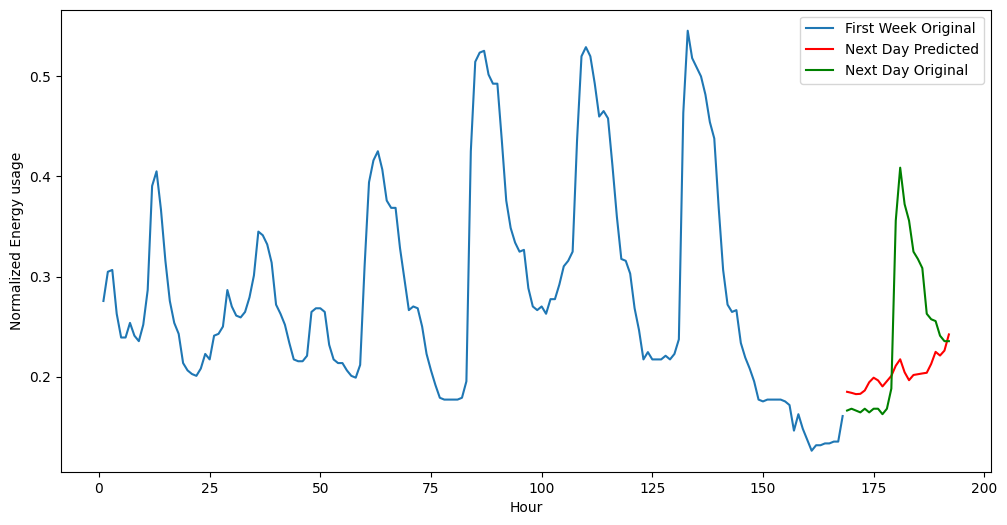

In [ ]:
plot_week(X_test, y_test, y_pred, n=3)

### 2D-CNN

In [ ]:
# source = https://arxiv.org/pdf/1409.1556.pdf

def vgg_block(model, num_convs, num_filters, kernel_size=3, dilation_rate=1):
    for _ in range(num_convs):
        model.add(Conv2D(num_filters, kernel_size, activation='relu', padding='same', dilation_rate=1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    return model

# Instantiate the model
model = Sequential(name="VGG16")

# Input layer
model.add(Input(shape=(timesteps, features, 1)))

# Add VGG blocks
model = vgg_block(model, 2, 64, kernel_size=(3,3))
model = vgg_block(model, 2, 128, kernel_size=(3,3))
model.add(Flatten())

# FC layers
model.add(Dense(2**8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation='sigmoid'))

model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 168, 23, 64)       640       
                                                                 
 conv2d_5 (Conv2D)           (None, 168, 23, 64)       36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 84, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 84, 11, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 84, 11, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 5, 128)       0         
 2D)                                                         

#### No Weather

In [ ]:
# NO WEATHER
history = compile_and_fit(model, train_gen, (X_val, y_val), 50, ft=False)

Epoch 1/50
2012/2013 [============================>.] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0451
Epoch 1: val_loss improved from inf to 0.00240, saving model to VGG16_best.h5
2013/2013 [==============================] - 41s 20ms/step - loss: 0.0044 - mean_absolute_error: 0.0451 - val_loss: 0.0024 - val_mean_absolute_error: 0.0308
Epoch 2/50
2013/2013 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0333
Epoch 2: val_loss improved from 0.00240 to 0.00214, saving model to VGG16_best.h5
2013/2013 [==============================] - 39s 19ms/step - loss: 0.0022 - mean_absolute_error: 0.0333 - val_loss: 0.0021 - val_mean_absolute_error: 0.0283
Epoch 3/50
2012/2013 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0308
Epoch 3: val_loss improved from 0.00214 to 0.00199, saving model to VGG16_best.h5
2013/2013 [==============================] - 37s 19ms/step - loss: 0.0019 - mean_absolute_error: 0.0308 - val_loss: 0

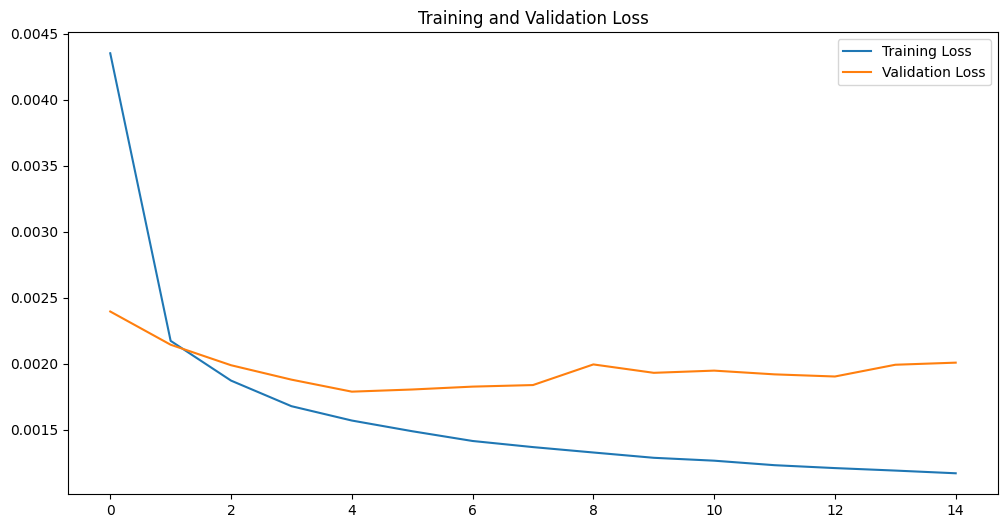

In [ ]:
plot_history(history)

In [ ]:
# Unnormalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 4s 3ms/step
Overall MAE: 12.713698387145996 , Overall MSE: 385.30511474609375, Approx. MAPE: 16.496296226978302


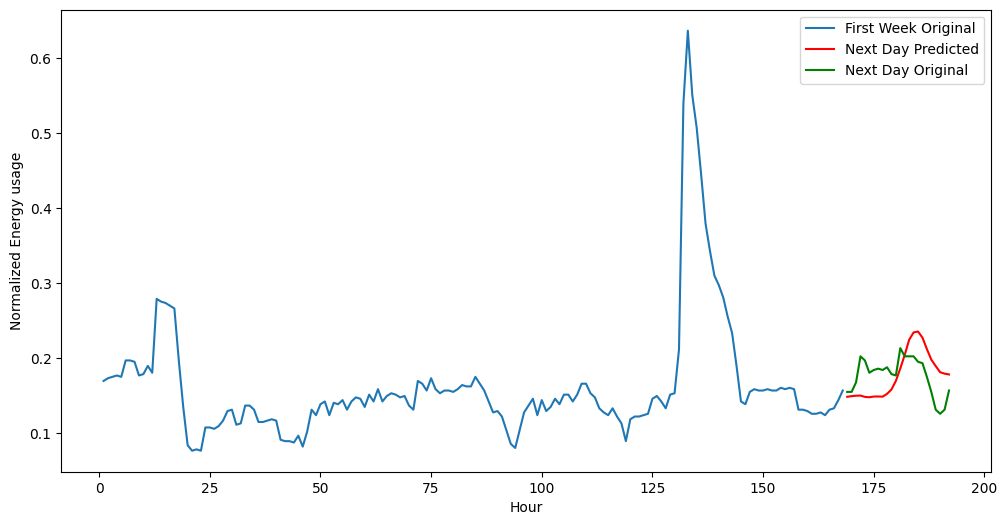

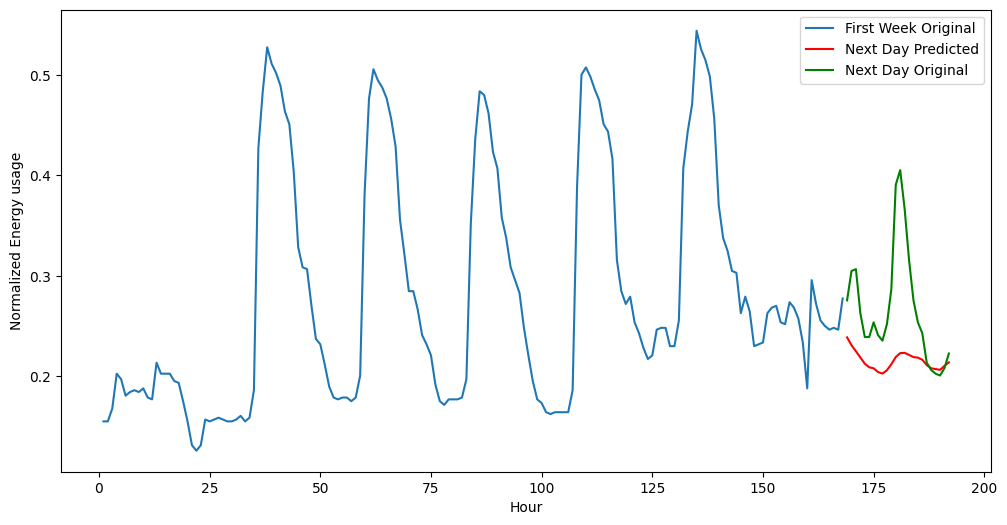

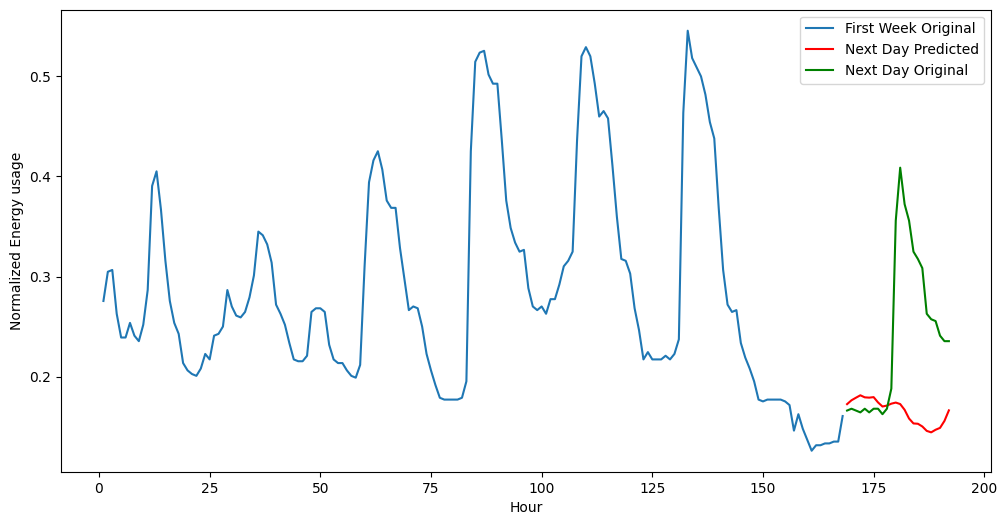

In [ ]:
plot_week(X_test, y_test, y_pred, n=3)

#### Weather

In [ ]:
# WEATHER
history = compile_and_fit(model, train_gen, (X_val, y_val), 50, ft=False)

Epoch 1/50
2012/2013 [============================>.] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.0431
Epoch 1: val_loss improved from inf to 0.00246, saving model to VGG16_best.h5
2013/2013 [==============================] - 49s 23ms/step - loss: 0.0039 - mean_absolute_error: 0.0431 - val_loss: 0.0025 - val_mean_absolute_error: 0.0314
Epoch 2/50
2011/2013 [============================>.] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0330
Epoch 2: val_loss improved from 0.00246 to 0.00209, saving model to VGG16_best.h5
2013/2013 [==============================] - 48s 24ms/step - loss: 0.0021 - mean_absolute_error: 0.0330 - val_loss: 0.0021 - val_mean_absolute_error: 0.0280
Epoch 3/50
2012/2013 [============================>.] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0301
Epoch 3: val_loss improved from 0.00209 to 0.00191, saving model to VGG16_best.h5
2013/2013 [==============================] - 46s 23ms/step - loss: 0.0018 - mean_absolute_error: 0.0301 - val_loss: 0

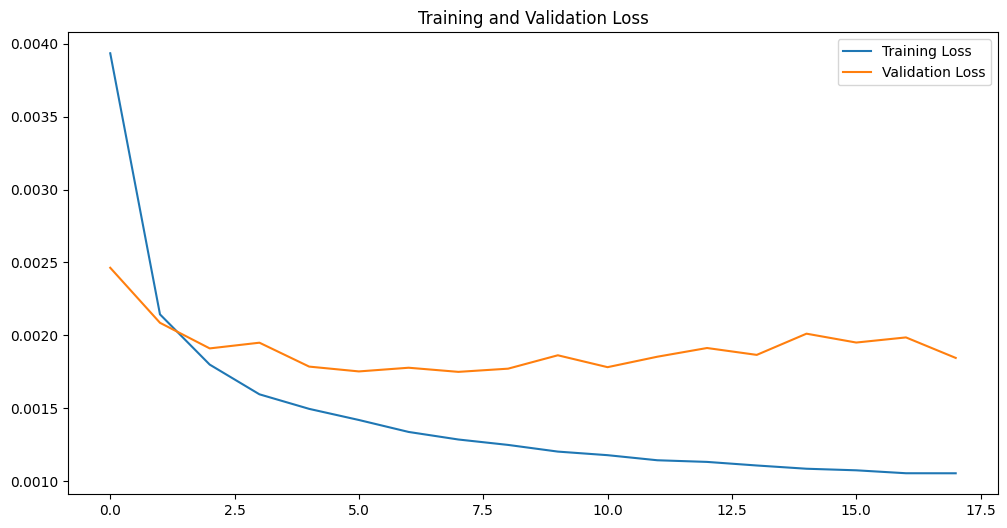

In [ ]:
plot_history(history)

In [ ]:
model = load_model('/content/VGG16_best_weather.h5')

In [ ]:
# Unnormalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 4s 3ms/step
Overall MAE: 12.693246841430664 , Overall MSE: 380.1078186035156, Approx. MAPE: 16.469760239124298


In [ ]:
# Evaluating on test set normalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 4s 3ms/step
Overall MAE: 0.023685336112976074 , Overall MSE: 0.0013331712689250708 , 


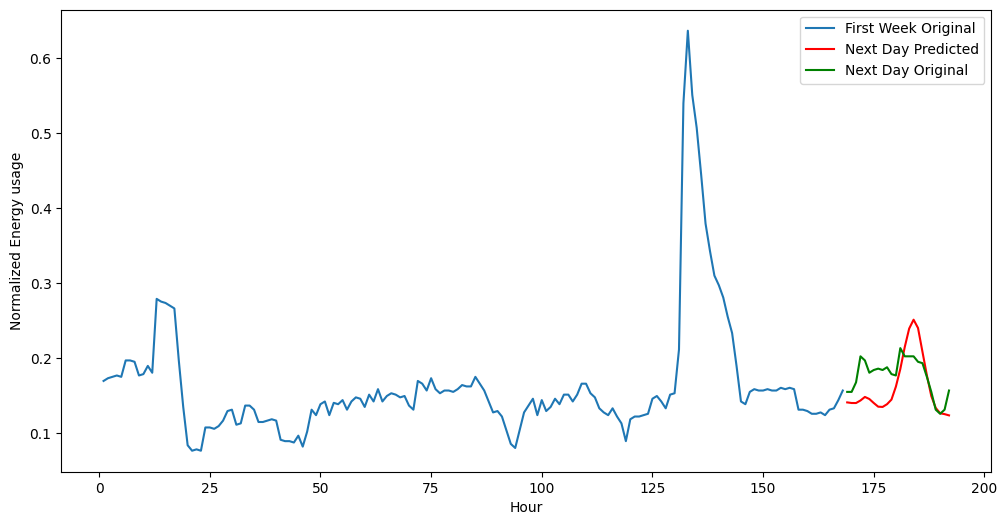

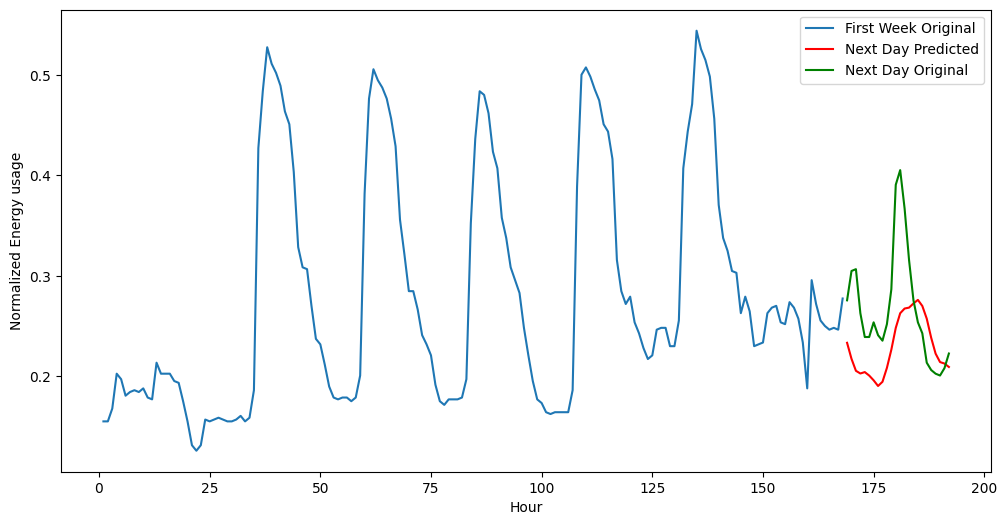

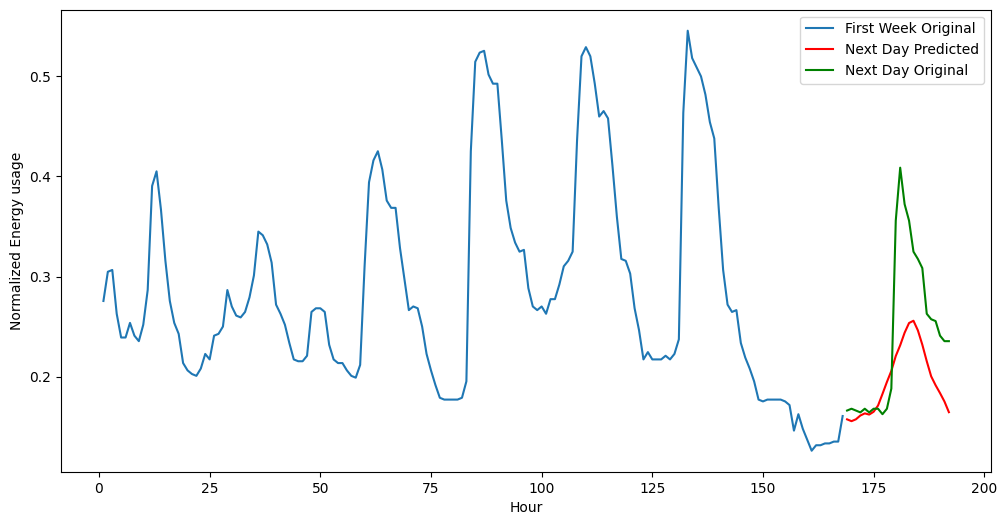

In [ ]:
plot_week(X_test, y_test, y_pred, n=3)

## Hyper-Parameter Tuning

In [ ]:
# Tuning 2DCNN model
def vgg_block(model, num_convs, num_filters, kernel_size=3, dilation_rate=1):
    for _ in range(num_convs):
        model.add(Conv2D(num_filters, kernel_size, activation='relu', padding='same', dilation_rate=1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    return model

def vggnet(hp):
  model = Sequential(name="VGG-Custom")
  model.add(Input(shape=(timesteps, features, 1)))

  start_from = hp.Choice('start_from', values=[16, 32, 64, 128])

  depth = hp.Choice('depth', values=[2, 3])

  for i in range(depth):
    dilation_rate = hp.Choice('dr_'+str(i), values=[1, 2])
    kernel_size = (hp.Choice('ks1_'+str(i), values=[1, 3, 5, 8]), hp.Choice('ks2_'+str(i), values=[1, 3, 5, 8]))
    model = vgg_block(model, 2, start_from * (2**i), kernel_size=kernel_size, dilation_rate=dilation_rate)

  # Flatten the output for the FC layers
  model.add(Flatten())

  # FC layers
  model.add(Dense(2**8, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(24, activation='sigmoid'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='mse',
                metrics=['mae'])

  return model

tuner = kt.Hyperband(vggnet,
                    objective='val_loss',
                    max_epochs=15,
                    factor=3,
                    directory='2DCNN_TUNING_1',
                    project_name='TUNING_2DCNN_WITH_DATA')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_gen, epochs=50, validation_data=(X_val, y_val), steps_per_epoch=train_steps_per_epoch, callbacks=[stop_early])

Trial 30 Complete [00h 06m 07s]
val_loss: 0.0019880409818142653

Best val_loss So Far: 0.0017447798745706677
Total elapsed time: 02h 46m 42s


In [ ]:
tuner.results_summary()

Results summary
Results in 2DCNN_TUNING_1/TUNING_2DCNN_WITH_DATA
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0028 summary
Hyperparameters:
start_from: 32
depth: 2
dr_0: 1
ks1_0: 3
ks2_0: 3
dr_1: 1
ks1_1: 1
ks2_1: 3
dr_2: 2
ks1_2: 1
ks2_2: 8
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0017447798745706677

Trial 0025 summary
Hyperparameters:
start_from: 16
depth: 2
dr_0: 1
ks1_0: 3
ks2_0: 8
dr_1: 1
ks1_1: 5
ks2_1: 1
dr_2: 2
ks1_2: 5
ks2_2: 3
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.0017868687864392996

Trial 0024 summary
Hyperparameters:
start_from: 64
depth: 2
dr_0: 2
ks1_0: 1
ks2_0: 8
dr_1: 2
ks1_1: 3
ks2_1: 1
dr_2: 2
ks1_2: 5
ks2_2: 5
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.0017875571502372622

Trial 0017 summary
Hyperparameters:
start_from: 16
depth: 2
dr_0: 2
ks1_0: 1
ks2_0: 3
dr_1: 2
ks1_1: 8
ks

In [ ]:
# Get the best model from the tuner and save it
vgg_d_cnn_ht = tuner.get_best_models(num_models=1)[0]

model_json = vgg_d_cnn_ht.to_json()
with open("vgg_d_cnn_ht_config_new.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from tensorflow.keras.models import model_from_json

with open("vgg_d_cnn_ht_config_new.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Model without weights
loaded_model = model_from_json(loaded_model_json)

In [ ]:
loaded_model.summary()

Model: "VGG-Custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 24, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 168, 24, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 12, 64)        6208      
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 12, 64)        12352     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 6, 64)        0         
 2D)                                                    

### Re-training best architecture

In [ ]:
# Weather
history = compile_and_fit(loaded_model, train_gen, (X_val, y_val), 50, ft=False)

Epoch 1/50
2012/2013 [============================>.] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.0439
Epoch 1: val_loss improved from inf to 0.00245, saving model to VGG-Custom_best.h5
2013/2013 [==============================] - 42s 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0439 - val_loss: 0.0024 - val_mean_absolute_error: 0.0312
Epoch 2/50
2009/2013 [============================>.] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0342
Epoch 2: val_loss improved from 0.00245 to 0.00214, saving model to VGG-Custom_best.h5
2013/2013 [==============================] - 33s 16ms/step - loss: 0.0023 - mean_absolute_error: 0.0342 - val_loss: 0.0021 - val_mean_absolute_error: 0.0291
Epoch 3/50
2009/2013 [============================>.] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0321
Epoch 3: val_loss improved from 0.00214 to 0.00203, saving model to VGG-Custom_best.h5
2013/2013 [==============================] - 39s 19ms/step - loss: 0.0020 - mean_absolute_error: 0.032

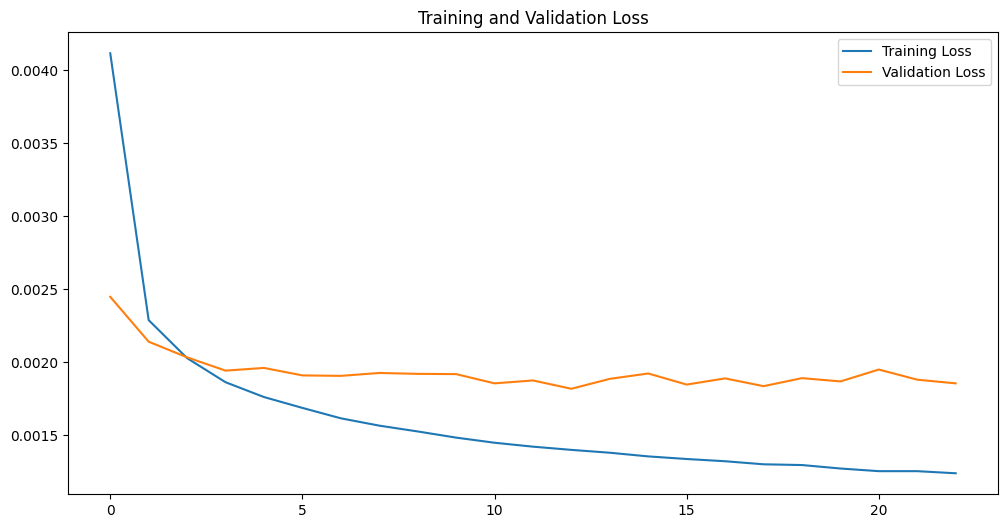

In [ ]:
plot_history(history)

In [ ]:
model = load_model('/content/VGG-Custom_best_weather_TUNED.h5')

In [ ]:
# Unnormalised
y_pred = model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 3s 2ms/step
Overall MAE: 12.5299072265625 , Overall MSE: 367.2881164550781, Approx. MAPE: 16.25782400369644


In [ ]:
# Testing on test set normalised
y_pred = loaded_model.predict(X_test)
eval(y_pred, y_test)

1343/1343 [==============================] - 4s 3ms/step
Overall MAE: 0.022832313552498817 , Overall MSE: 0.0012430965434759855 , 


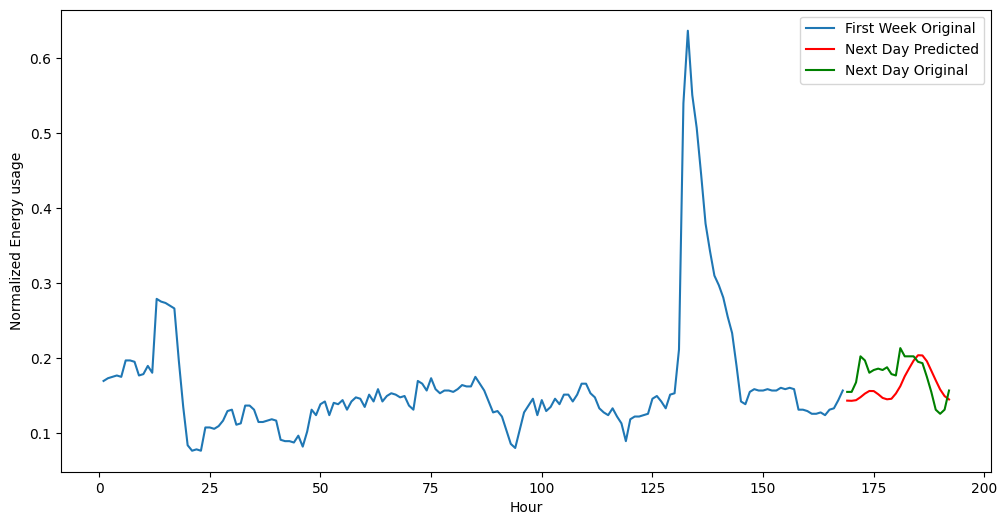

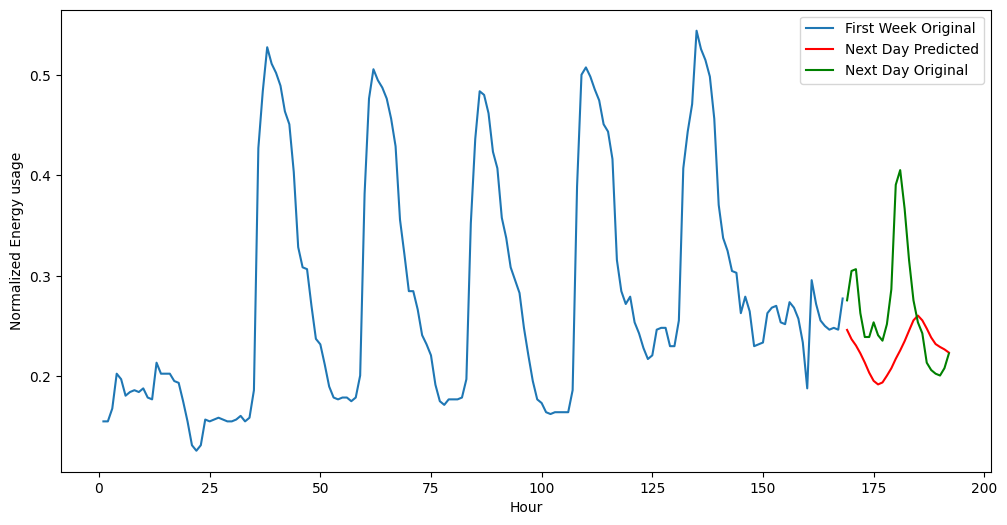

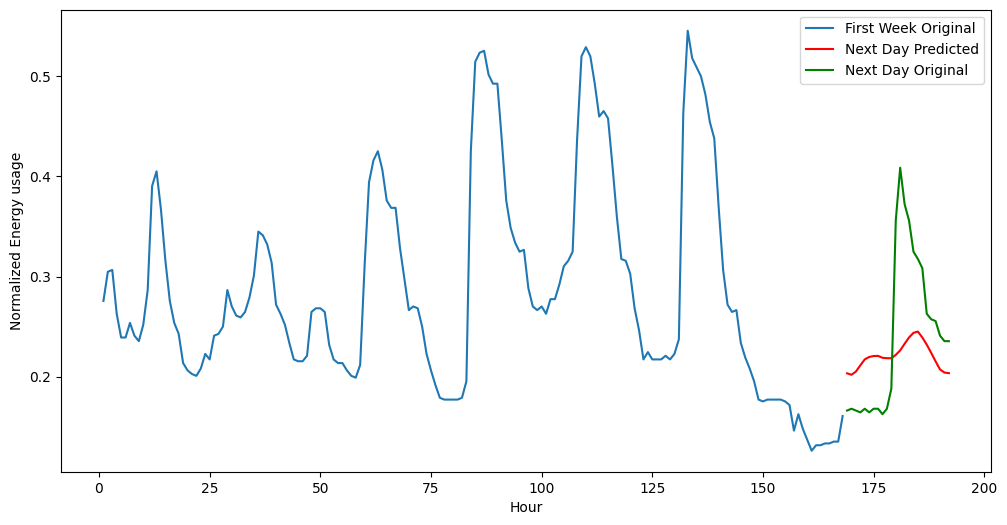

In [ ]:
plot_week(X_test, y_test, y_pred, n=3)

## Fine-Tuning

In [ ]:
!rm -rf /content/tuned_models

In [ ]:
def eval_ft(y_pred, y_test):
    y_pred = descale(y_pred)
    y_test = descale(y_test)
    # Reshape y_test and y_pred into continuous time series
    y_test_flat = y_test.ravel()
    y_pred_flat = y_pred.ravel()

    # Print mae and mse
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mape = (mae / np.mean(y_test)) *100

    return (f"Overall MAE: {mae} , Overall MSE: {mse}, Approx. MAPE: {mape}"), mape

def finetune_dataset(N):
  X_train, y_train = [], []
  X_test, y_test = [], []

  for school in test:
    x, y = get_school(school)
    X_train.append(x[:N])
    y_train.append(y[:N])
    X_test.append(x[N:])
    y_test.append(y[N:])

  return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

def freeze_comp(model, i, N):
  # Freeze all layers but the last one
  for layer in model.layers[:-1]:
    layer.trainable = False
  # Reduce learning rate to reduce chance of overfitting
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse', metrics=['mae'])
  checkpoint = ModelCheckpoint(f"/content/tuned_models/SchoolID:{test[i]}/VGG-Custom_W_HT_FT_{(N/24)/7}.h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
  return model, checkpoint

def finetune(N):
  evals = []
  histories = []
  mapes = 0
  X_train, y_train, X_test, y_test = finetune_dataset(N)
  # First two schools are in different locations
  for i in range(2):
    model, checkpoint = freeze_comp(load_model('/content/VGG-Custom_best_weather_HT.h5'), i, N)
    history = model.fit(X_train[i], y_train[i], epochs=10, callbacks=[checkpoint])
    histories.append(history)
    y_pred = model.predict(X_test[i])
    eval_res, mape = eval_ft(y_pred, y_test[i])
    mapes += mape
    evals.append(eval_res)
  return evals, mapes


#### FINE-TUNE ON 2 WEEKS

In [ ]:
# FINE-TUNE ON 2 WEEKS
# Number of weeks to fine-tune on
N = 24 * 7 * 2
evals, mapes = finetune(N)

# FINE-TUNING ON 2 WEEKS
for i in range(2):
  print(f"School ID: {test[i]}, Evaluation: {evals[i]}")

print(f"Overall Approx. MAPE on both schools: {mapes/2}")

Epoch 1/10
 1/11 [=>............................] - ETA: 11s - loss: 0.0074 - mae: 0.0638
Epoch 1: loss improved from inf to 0.00670, saving model to /content/tuned_models/SchoolID:101/VGG-Custom_W_HT_FT_2.0.h5
11/11 [==============================] - 1s 10ms/step - loss: 0.0067 - mae: 0.0631
Epoch 2/10
 1/11 [=>............................] - ETA: 0s - loss: 0.0064 - mae: 0.0622
Epoch 2: loss did not improve from 0.00670
11/11 [==============================] - 0s 5ms/step - loss: 0.0069 - mae: 0.0641
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0639
Epoch 3: loss did not improve from 0.00670
11/11 [==============================] - 0s 6ms/step - loss: 0.0070 - mae: 0.0639
Epoch 4/10
 1/11 [=>............................] - ETA: 0s - loss: 0.0087 - mae: 0.0698
Epoch 4: loss did not improve from 0.00670
11/11 [==============================] - 0s 5ms/step - loss: 0.0068 - mae: 0.0638
Epoch 5/10
 1/11 [=>............................] - ETA: 0s - lo

#### FINE-TUNING ON 4 WEEKS

In [ ]:
# FINE-TUNING ON 4 WEEKS
# Number of weeks to fine-tune on
N = 24 * 7 * 4
evals, mapes = finetune(N)

for i in range(2):
  print(f"School ID: {test[i]}, Evaluation: {evals[i]}")

print(f"Overall Approx. MAPE on both schools: {mapes/2}")

Epoch 1/10
15/21 [====================>.........] - ETA: 0s - loss: 0.0061 - mae: 0.0603 
Epoch 1: loss improved from inf to 0.00617, saving model to /content/tuned_models/SchoolID:101/VGG-Custom_W_HT_FT_4.0.h5
21/21 [==============================] - 1s 6ms/step - loss: 0.0062 - mae: 0.0604
Epoch 2/10
15/21 [====================>.........] - ETA: 0s - loss: 0.0062 - mae: 0.0608
Epoch 2: loss improved from 0.00617 to 0.00615, saving model to /content/tuned_models/SchoolID:101/VGG-Custom_W_HT_FT_4.0.h5
21/21 [==============================] - 0s 7ms/step - loss: 0.0062 - mae: 0.0608
Epoch 3/10
15/21 [====================>.........] - ETA: 0s - loss: 0.0063 - mae: 0.0615
Epoch 3: loss did not improve from 0.00615
21/21 [==============================] - 0s 4ms/step - loss: 0.0063 - mae: 0.0612
Epoch 4/10
15/21 [====================>.........] - ETA: 0s - loss: 0.0060 - mae: 0.0600
Epoch 4: loss improved from 0.00615 to 0.00615, saving model to /content/tuned_models/SchoolID:101/VGG-Custo

#### FINE-TUNING ON 8 WEEKS

In [ ]:
# FINE-TUNING ON 8 WEEKS
# Number of weeks to fine-tune on
N = 24 * 7 * 8
evals, mapes = finetune(N)

for i in range(2):
  print(f"School ID: {test[i]}, Evaluation: {evals[i]}")

print(f"Overall Approx. MAPE on both schools: {mapes/2}")

Epoch 1/10
31/42 [=====================>........] - ETA: 0s - loss: 0.0058 - mae: 0.0590
Epoch 1: loss improved from inf to 0.00571, saving model to /content/tuned_models/SchoolID:101/VGG-Custom_W_HT_FT_8.0.h5
42/42 [==============================] - 1s 5ms/step - loss: 0.0057 - mae: 0.0583
Epoch 2/10
41/42 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0585
Epoch 2: loss improved from 0.00571 to 0.00571, saving model to /content/tuned_models/SchoolID:101/VGG-Custom_W_HT_FT_8.0.h5
42/42 [==============================] - 0s 5ms/step - loss: 0.0057 - mae: 0.0586
Epoch 3/10
39/42 [==========================>...] - ETA: 0s - loss: 0.0058 - mae: 0.0589
Epoch 3: loss did not improve from 0.00571
42/42 [==============================] - 0s 4ms/step - loss: 0.0058 - mae: 0.0586
Epoch 4/10
30/42 [====================>.........] - ETA: 0s - loss: 0.0057 - mae: 0.0582
Epoch 4: loss improved from 0.00571 to 0.00565, saving model to /content/tuned_models/SchoolID:101/VGG-Custom

#### FINE-TUNING ON 24 WEEKS

In [ ]:
# FINE-TUNING ON 24 WEEKS
# Number of weeks to fine-tune on
N = 24 * 7 * 24
evals, mapes = finetune(N)

for i in range(2):
  print(f"School ID: {test[i]}, Evaluation: {evals[i]}")

print(f"Overall Approx. MAPE on both schools: {mapes/2}")

Epoch 1/10
124/126 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0436
Epoch 1: loss improved from inf to 0.00386, saving model to /content/tuned_models/SchoolID:101/VGG-Custom_W_HT_FT_24.0.h5
126/126 [==============================] - 1s 4ms/step - loss: 0.0039 - mae: 0.0436
Epoch 2/10
123/126 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0435
Epoch 2: loss did not improve from 0.00386
126/126 [==============================] - 0s 4ms/step - loss: 0.0039 - mae: 0.0435
Epoch 3/10
122/126 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0436
Epoch 3: loss did not improve from 0.00386
126/126 [==============================] - 0s 4ms/step - loss: 0.0039 - mae: 0.0437
Epoch 4/10
115/126 [==========================>...] - ETA: 0s - loss: 0.0038 - mae: 0.0435
Epoch 4: loss improved from 0.00386 to 0.00382, saving model to /content/tuned_models/SchoolID:101/VGG-Custom_W_HT_FT_24.0.h5
126/126 [==============================] - 1s 4ms/